In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the California housing dataset
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target  # Add median house value as a column

# Create the response variable: 1 if MedHouseVal > median, 0 otherwise
median_value = data['MedHouseVal'].median()
data['high_value'] = (data['MedHouseVal'] > median_value).astype(int)
data = data.drop('MedHouseVal', axis=1)  # Drop original MedHouseVal column

# Define predictor subsets
subset1 = ['MedInc', 'HouseAge', 'AveRooms']  # Income, age, and room-related
subset2 = ['AveBedrms', 'Population', 'Latitude']  # Bedroom, population, and location-related
all_predictors = california.feature_names  # All 8 predictors

# Function to evaluate and print results, saving plots
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, subset_name, save_dir):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    
    # Create plot
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name} ({subset_name})")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Save plot
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plot_path = os.path.join(save_dir, f"{model_name.replace(' ', '_')}_{subset_name}_CM.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to free memory
    return accuracy

# Prepare data and scale features
scaler = StandardScaler()
X = data[all_predictors]
y = data['high_value']
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Subset indices for evaluation
# Use list comprehension to get indices based on feature names
subsets = {
    'Subset1': [all_predictors.index(col) for col in subset1],
    'Subset2': [all_predictors.index(col) for col in subset2],
    'All': list(range(len(all_predictors)))
}

# Define save directory
save_dir = r"D:\Documents\My docs\Academics\Notes\Data Mining"

# Initialize models
log_reg = LogisticRegression(max_iter=1000)
lda = LDA()
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)  # Start with k=5, will test others

# Evaluate each model with different subsets
for subset_name, indices in subsets.items():
    print(f"\nEvaluating models with {subset_name} predictors")
    X_train_subset = X_train[:, indices]
    X_test_subset = X_test[:, indices]

    # Logistic Regression
    evaluate_model(log_reg, X_train_subset, X_test_subset, y_train, y_test, f"Logistic Regression", subset_name, save_dir)

    # LDA
    evaluate_model(lda, X_train_subset, X_test_subset, y_train, y_test, f"LDA", subset_name, save_dir)

    # Naive Bayes
    evaluate_model(nb, X_train_subset, X_test_subset, y_train, y_test, f"Naive Bayes", subset_name, save_dir)

    # KNN (test different k values)
    k_values = [1, 3, 5, 10]
    for k in k_values:
        knn_k = KNeighborsClassifier(n_neighbors=k)
        evaluate_model(knn_k, X_train_subset, X_test_subset, y_train, y_test, f"KNN k={k}", subset_name, save_dir)

# Optional: Find optimal k for KNN with all predictors and save plot
k_range = range(1, 21)
scores = []
X_train_all = X_train[:, subsets['All']]
X_test_all = X_test[:, subsets['All']]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_all, y_train)
    scores.append(accuracy_score(y_test, knn.predict(X_test_all)))

plt.figure()
plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('KNN Accuracy vs k Value (All Predictors)')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plot_path = os.path.join(save_dir, "KNN_Accuracy_vs_k_All_Predictors.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"Optimal k for KNN (All predictors): {k_range[np.argmax(scores)]} with accuracy {max(scores):.4f}")


Evaluating models with Subset1 predictors
Logistic Regression - Accuracy: 0.7713, AUC: 0.8555
LDA - Accuracy: 0.7657, AUC: 0.8486
Naive Bayes - Accuracy: 0.7345, AUC: 0.8132
KNN k=1 - Accuracy: 0.7129, AUC: 0.7129
KNN k=3 - Accuracy: 0.7450, AUC: 0.8052
KNN k=5 - Accuracy: 0.7642, AUC: 0.8325
KNN k=10 - Accuracy: 0.7729, AUC: 0.8529

Evaluating models with Subset2 predictors
Logistic Regression - Accuracy: 0.5601, AUC: 0.5914
LDA - Accuracy: 0.5589, AUC: 0.5918
Naive Bayes - Accuracy: 0.5554, AUC: 0.6095
KNN k=1 - Accuracy: 0.6256, AUC: 0.6257
KNN k=3 - Accuracy: 0.6492, AUC: 0.6955
KNN k=5 - Accuracy: 0.6591, AUC: 0.7156
KNN k=10 - Accuracy: 0.6694, AUC: 0.7376

Evaluating models with All predictors
Logistic Regression - Accuracy: 0.8272, AUC: 0.9102
LDA - Accuracy: 0.8169, AUC: 0.9035
Naive Bayes - Accuracy: 0.7211, AUC: 0.8400
KNN k=1 - Accuracy: 0.8089, AUC: 0.8089
KNN k=3 - Accuracy: 0.8304, AUC: 0.8910
KNN k=5 - Accuracy: 0.8337, AUC: 0.9075
KNN k=10 - Accuracy: 0.8366, AUC: 0.9


Evaluating models with Subset1 predictors
Logistic Regression (Subset1) - Accuracy: 0.7713, AUC: 0.8555


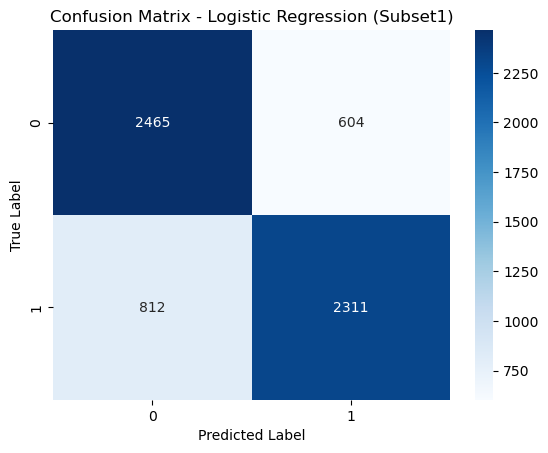

LDA (Subset1) - Accuracy: 0.7657, AUC: 0.8486


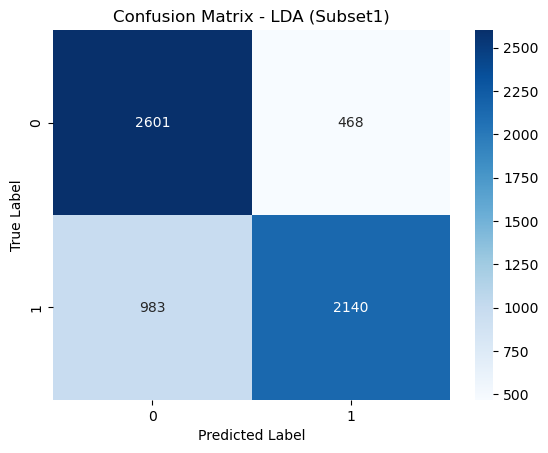

Naive Bayes (Subset1) - Accuracy: 0.7345, AUC: 0.8132


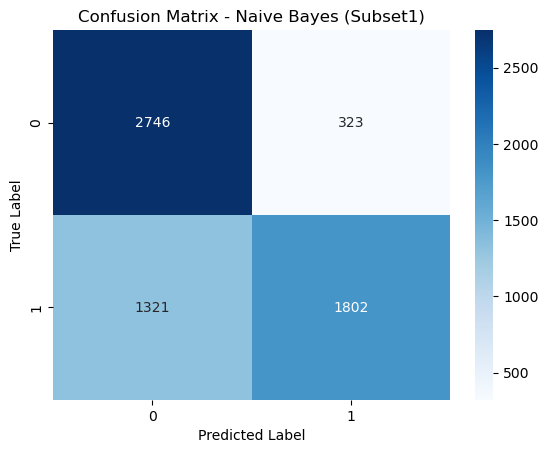

KNN k=1 (Subset1) - Accuracy: 0.7129, AUC: 0.7129


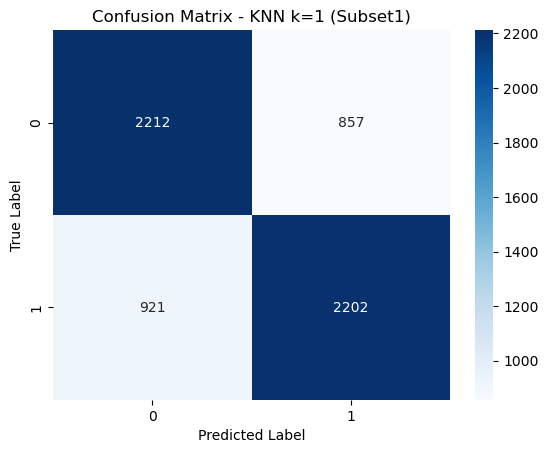

KNN k=3 (Subset1) - Accuracy: 0.7450, AUC: 0.8052


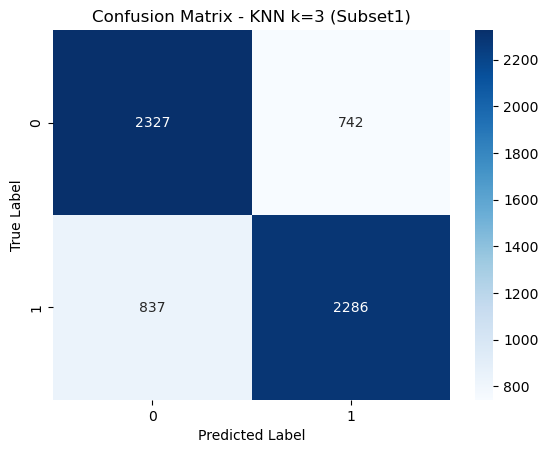

KNN k=5 (Subset1) - Accuracy: 0.7642, AUC: 0.8325


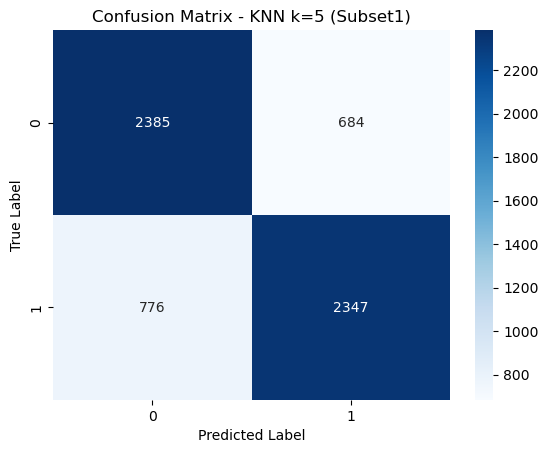

KNN k=10 (Subset1) - Accuracy: 0.7729, AUC: 0.8529


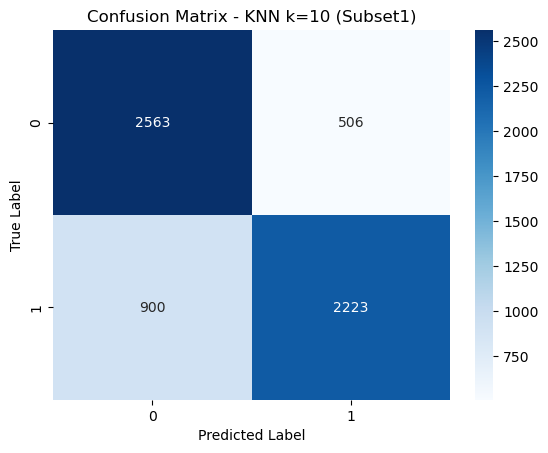


Evaluating models with Subset2 predictors
Logistic Regression (Subset2) - Accuracy: 0.5601, AUC: 0.5914


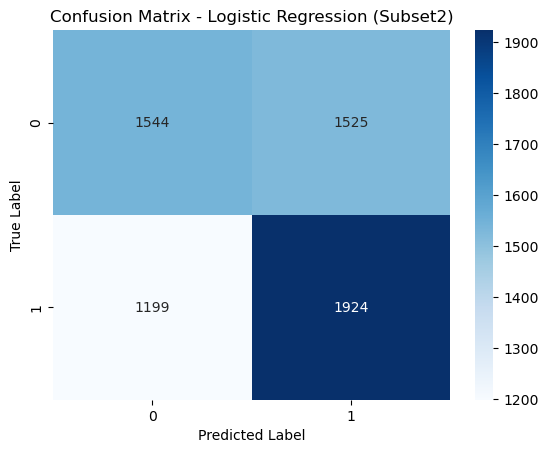

LDA (Subset2) - Accuracy: 0.5589, AUC: 0.5918


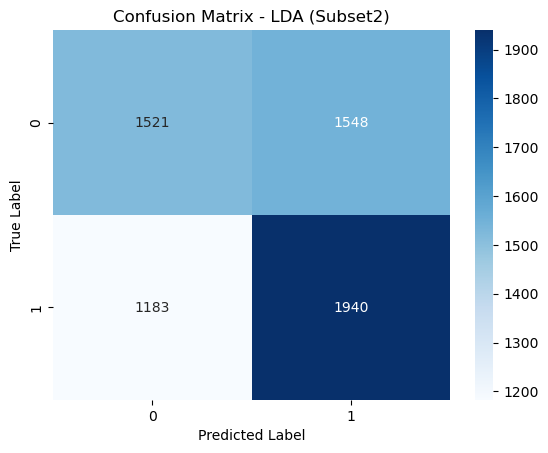

Naive Bayes (Subset2) - Accuracy: 0.5554, AUC: 0.6095


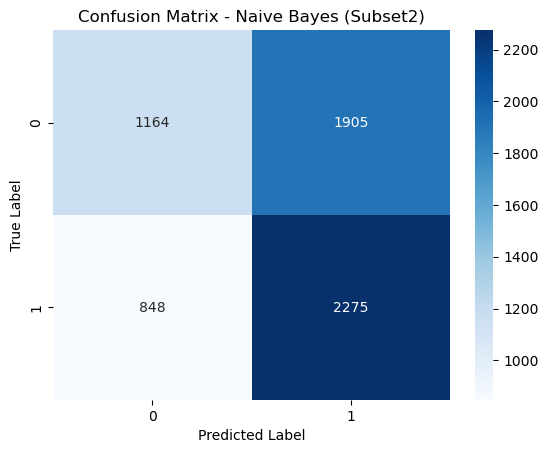

KNN k=1 (Subset2) - Accuracy: 0.6256, AUC: 0.6257


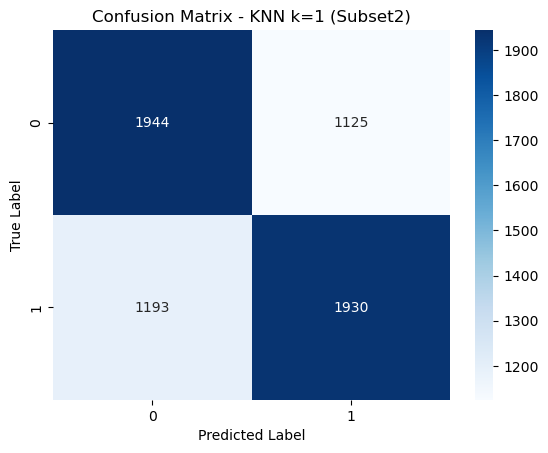

KNN k=3 (Subset2) - Accuracy: 0.6492, AUC: 0.6955


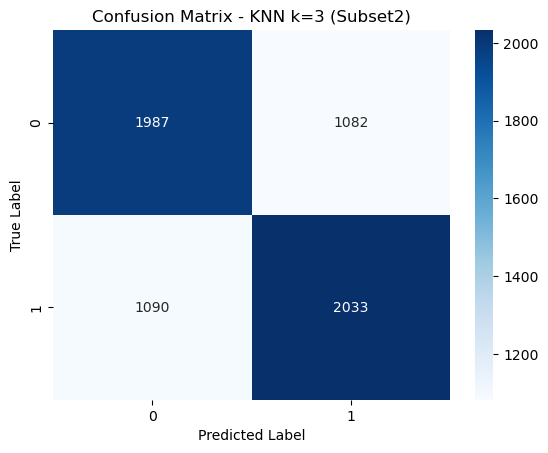

KNN k=5 (Subset2) - Accuracy: 0.6591, AUC: 0.7156


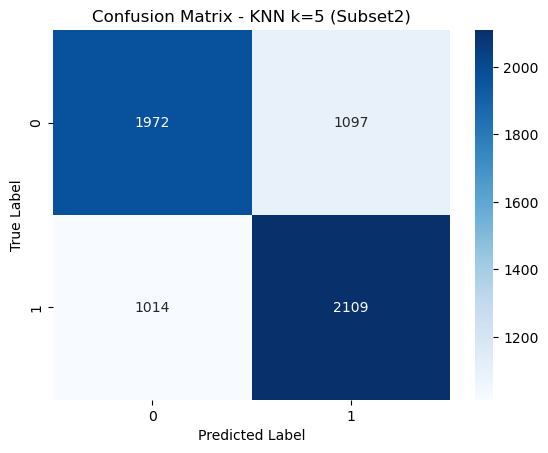

KNN k=10 (Subset2) - Accuracy: 0.6694, AUC: 0.7376


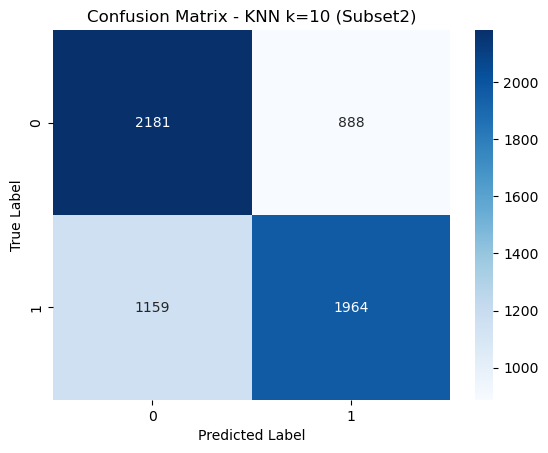


Evaluating models with All predictors
Logistic Regression (All) - Accuracy: 0.8272, AUC: 0.9102


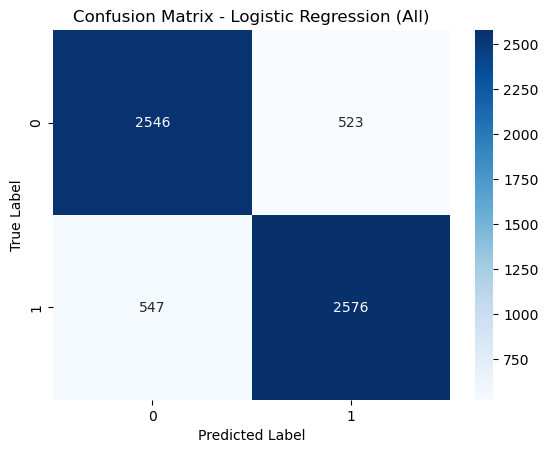

LDA (All) - Accuracy: 0.8169, AUC: 0.9035


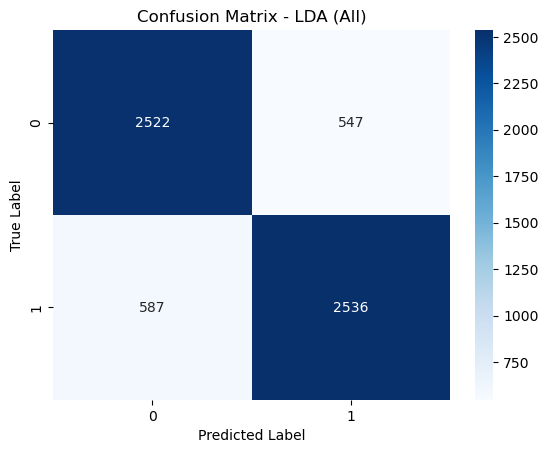

Naive Bayes (All) - Accuracy: 0.7211, AUC: 0.8400


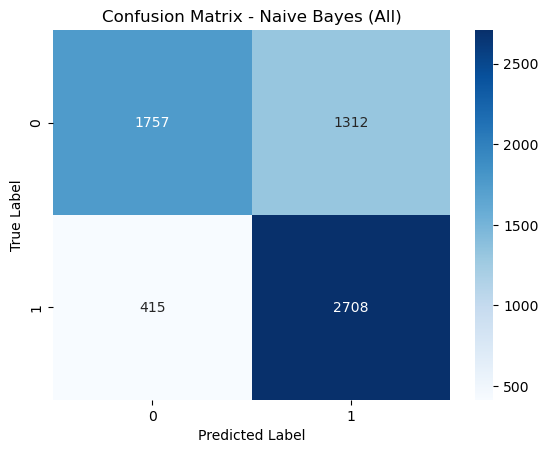

KNN k=1 (All) - Accuracy: 0.8089, AUC: 0.8089


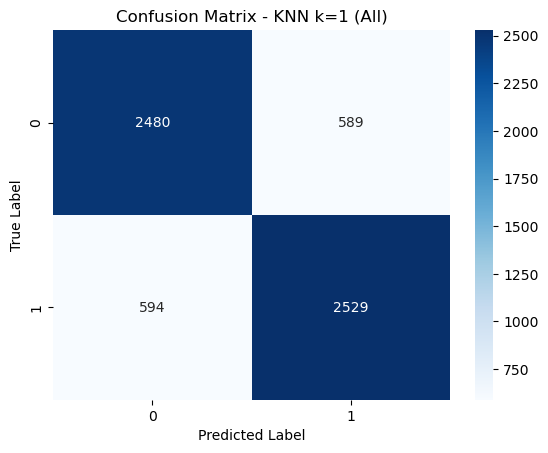

KNN k=3 (All) - Accuracy: 0.8304, AUC: 0.8910


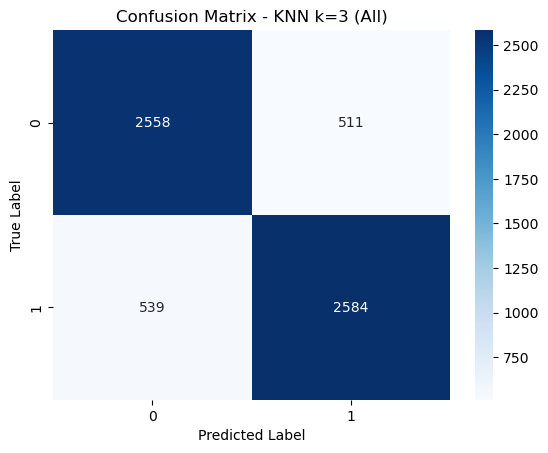

KNN k=5 (All) - Accuracy: 0.8337, AUC: 0.9075


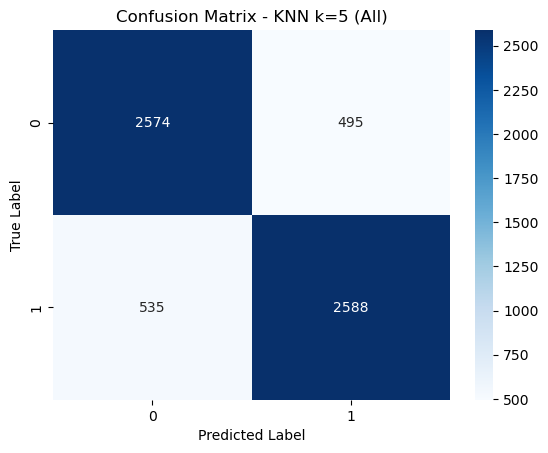

KNN k=10 (All) - Accuracy: 0.8366, AUC: 0.9197


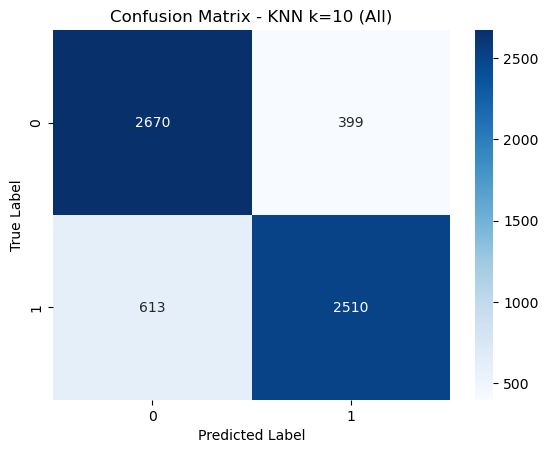

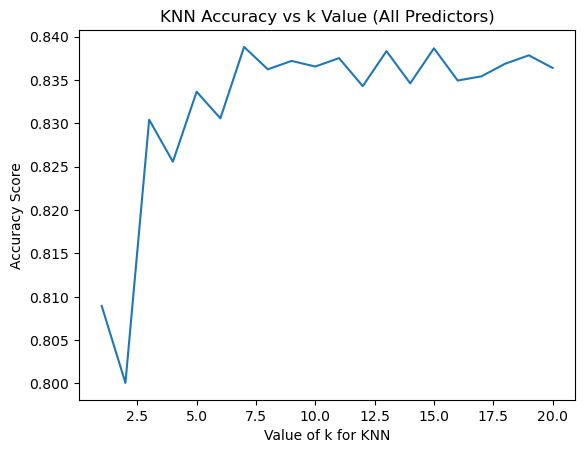

Optimal k for KNN (All predictors): 7 with accuracy 0.8388


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the California housing dataset
california = fetch_california_housing()
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target  # Add median house value as a column

# Create the response variable: 1 if MedHouseVal > median, 0 otherwise
median_value = data['MedHouseVal'].median()
data['high_value'] = (data['MedHouseVal'] > median_value).astype(int)
data = data.drop('MedHouseVal', axis=1)  # Drop original MedHouseVal column

# Define predictor subsets
subset1 = ['MedInc', 'HouseAge', 'AveRooms']  # Income, age, and room-related
subset2 = ['AveBedrms', 'Population', 'Latitude']  # Bedroom, population, and location-related
all_predictors = california.feature_names  # All 8 predictors

# Function to evaluate and print results
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return accuracy

# Prepare data and scale features
scaler = StandardScaler()
X = data[all_predictors]
y = data['high_value']
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Subset indices for evaluation
# Use list comprehension to get indices based on feature names
subsets = {
    'Subset1': [all_predictors.index(col) for col in subset1],
    'Subset2': [all_predictors.index(col) for col in subset2],
    'All': list(range(len(all_predictors)))
}

# Initialize models
log_reg = LogisticRegression(max_iter=1000)
lda = LDA()
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)  # Start with k=5, will test others

# Evaluate each model with different subsets
for subset_name, indices in subsets.items():
    print(f"\nEvaluating models with {subset_name} predictors")
    X_train_subset = X_train[:, indices]
    X_test_subset = X_test[:, indices]

    # Logistic Regression
    evaluate_model(log_reg, X_train_subset, X_test_subset, y_train, y_test, f"Logistic Regression ({subset_name})")

    # LDA
    evaluate_model(lda, X_train_subset, X_test_subset, y_train, y_test, f"LDA ({subset_name})")

    # Naive Bayes
    evaluate_model(nb, X_train_subset, X_test_subset, y_train, y_test, f"Naive Bayes ({subset_name})")

    # KNN (test different k values)
    k_values = [1, 3, 5, 10]
    for k in k_values:
        knn_k = KNeighborsClassifier(n_neighbors=k)
        accuracy = evaluate_model(knn_k, X_train_subset, X_test_subset, y_train, y_test, f"KNN k={k} ({subset_name})")

# Optional: Find optimal k for KNN with all predictors
k_range = range(1, 21)
scores = []
X_train_all = X_train[:, subsets['All']]
X_test_all = X_test[:, subsets['All']]
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_all, y_train)
    scores.append(accuracy_score(y_test, knn.predict(X_test_all)))

plt.figure()
plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('KNN Accuracy vs k Value (All Predictors)')
plt.show()
print(f"Optimal k for KNN (All predictors): {k_range[np.argmax(scores)]} with accuracy {max(scores):.4f}")